![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# 4. Named Entity Recognition (NER) DL Training v2.6.3

## Blogposts and videos:

https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77

NerDL worksghop (90 min): https://www.youtube.com/watch?v=YM-e4eOiQ34

https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571

https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180

In [0]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v2.4.5 
 Master 
 spark://10.164.246.233:7077 
 AppName 
 Databricks Shell

## CoNLL Data Prep

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.train
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.testa

In [0]:
with open("eng.train") as f:
    train_txt =f.read()

print (train_txt[:500])

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER

BRUSSELS NNP B-NP B-LOC
1996-08-22 CD I-NP O

The DT B-NP O
European NNP I-NP B-ORG
Commission NNP I-NP I-ORG
said VBD B-VP O
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP

In [0]:
from sparknlp.training import CoNLL

training_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.train')

training_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
EU rejects German...|[[document, 0, 47...|[[document, 0, 47...|[[token, 0, 1, EU...|[[pos, 0, 1, NNP,...|[[named_entity, 0...|
 Peter Blackburn|[[document, 0, 14...|[[document, 0, 14...|[[token, 0, 4, Pe...|[[pos, 0, 4, NNP,...|[[named_entity, 0...|
 BRUSSELS 1996-08-22|[[document, 0, 18...|[[document, 0, 18...|[[token, 0, 7, BR...|[[pos, 0, 7, NNP,...|[[named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
training_data.printSchema()

root
-- text: string (nullable = true)
-- document: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- sentence: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- token: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- pos: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- label: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)

In [0]:
training_data.count()

Out[5]: 14041

In [0]:
training_data.cache()

Out[6]: DataFrame[text: string, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentence: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, token: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, pos: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, label: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>]

In [0]:
%time training_data.count()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.14 s
Out[7]: 14041

In [0]:
%time training_data.count()

CPU times: user 943 µs, sys: 0 ns, total: 943 µs
Wall time: 670 ms

14041

In [0]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip('token.result', 'pos.result',  'label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("pos"),
        F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+----------+---+---------+
 token|pos|ner_label|
+----------+---+---------+
 EU|NNP| B-ORG|
 rejects|VBZ| O|
 German| JJ| B-MISC|
 call| NN| O|
 to| TO| O|
 boycott| VB| O|
 British| JJ| B-MISC|
 lamb| NN| O|
 .| .| O|
 Peter|NNP| B-PER|
 Blackburn|NNP| I-PER|
 BRUSSELS|NNP| B-LOC|
1996-08-22| CD| O|
 The| DT| O|
 European|NNP| B-ORG|
Commission|NNP| I-ORG|
 said|VBD| O|
 on| IN| O|
 Thursday|NNP| O|
 it|PRP| O|
+----------+---+---------+
only showing top 20 rows

In [0]:

training_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------+------+
ground_truth|count |
+------------+------+
O |169578|
B-LOC |7140 |
B-PER |6600 |
B-ORG |6321 |
I-PER |4528 |
I-ORG |3704 |
B-MISC |3438 |
I-LOC |1157 |
I-MISC |1155 |
+------------+------+

In [0]:
# You can use any word embeddings you want (Glove, Elmo, Bert, custom etc.)

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")
    

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][OK!]

In [0]:
!mkdir ner_logs

In [0]:
nerTagger = NerDLApproach()\
  .setInputCols(["sentence", "token", "embeddings"])\
  .setLabelColumn("label")\
  .setOutputCol("ner")\
  .setMaxEpochs(1)\
  .setLr(0.003)\
  .setBatchSize(32)\
  .setRandomSeed(0)\
  .setVerbose(1)\
  .setValidationSplit(0.2)\
  .setEvaluationLogExtended(True) \
  .setEnableOutputLogs(True)\
  .setIncludeConfidence(True)\
  .setOutputLogsPath('ner_logs') # if not set, logs will be written to ~/annotator_logs
 #.setGraphFolder('graphs') >> put your graph file (pb) under this folder if you are using a custom graph generated thru 4.1 NerDL-Graph.ipynb notebook
 # .setEnableMemoryOptimizer() >> if you have a limited memory and a large conll file, you can set this True to train batch by batch 
    
ner_pipeline = Pipeline(stages=[
          glove_embeddings,
          nerTagger
 ])


### Fitting

In [0]:

ner_model = ner_pipeline.fit(training_data)

# 1 epoch takes around 3 min with batch size=32
# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook to create a graph (or see the bottom cell of this notebook)

In [0]:
%sh cd /databricks/driver/ner_logs && pwd && ls -l

/databricks/driver/ner_logs
total 4
-rw-r--r-- 1 root root 1001 Oct 30 09:09 NerDLApproach_4f00276baa1c.log

In [0]:
#%sh head -n 45 ner_logs/NerDLApproach_4f00276baa1c.log

Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 1 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 11191


Epoch 1/1 started, lr: 0.003, dataset size: 11191


Epoch 1/1 - 36.94s - loss: 1059.8821 - batches: 352
Quality on validation dataset (20.0%), validation examples = 2238
time to finish evaluation: 4.21s
label tp fp fn prec rec f1
B-LOC 1282 74 93 0.9454277 0.9323636 0.9388502
I-ORG 637 97 125 0.8678474 0.835958 0.8516042
I-MISC 136 25 94 0.8447205 0.59130436 0.6956521
I-LOC 164 16 51 0.9111111 0.7627907 0.8303797
I-PER 933 37 15 0.96185565 0.98417723 0.9728884
B-MISC 523 54 139 0.9064125 0.79003024 0.8442292
B-ORG 1109 156 165 0.87667984 0.8704867 0.8735723
B-PER 1295 119 51 0.9158416 0.96211 0.9384058
tp: 6079 fp: 578 fn: 733 labels: 8
Macro-average prec: 0.90373707, rec: 0.84115267, f1: 0.8713225
Micro-average prec: 0.9131741, rec: 0.8923958, f1: 0.9026654

In [0]:
from sparknlp.training import CoNLL

test_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.testa')

test_data = glove_embeddings.transform(test_data)

test_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label| embeddings|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
CRICKET - LEICEST...|[[document, 0, 64...|[[document, 0, 64...|[[token, 0, 6, CR...|[[pos, 0, 6, NNP,...|[[named_entity, 0...|[[word_embeddings...|
 LONDON 1996-08-30|[[document, 0, 16...|[[document, 0, 16...|[[token, 0, 5, LO...|[[pos, 0, 5, NNP,...|[[named_entity, 0...|[[word_embeddings...|
West Indian all-r...|[[document, 0, 18...|[[document, 0, 18...|[[token, 0, 3, We...|[[pos, 0, 3, NNP,...|[[named_entity, 0...|[[word_embeddings...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
predictions = ner_model.transform(test_data)
predictions.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label| embeddings| ner|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
CRICKET - LEICEST...|[[document, 0, 64...|[[document, 0, 64...|[[token, 0, 6, CR...|[[pos, 0, 6, NNP,...|[[named_entity, 0...|[[word_embeddings...|[[named_entity, 0...|
 LONDON 1996-08-30|[[document, 0, 16...|[[document, 0, 16...|[[token, 0, 5, LO...|[[pos, 0, 5, NNP,...|[[named_entity, 0...|[[word_embeddings...|[[named_entity, 0...|
West Indian all-r...|[[document, 0, 18...|[[document, 0, 18...|[[token, 0, 3, We...|[[pos, 0, 3, NNP,...|[[named_entity, 0...|[[word_embeddings...|[[named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
predictions.select('token.result','label.result','ner.result').show(3, truncate=50)

+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
 result| result| result|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
[CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, TO...| [O, O, B-ORG, O, O, O, O, O, O, O, O]| [O, O, B-ORG, O, O, O, O, O, O, O, O]|
 [LONDON, 1996-08-30]| [B-LOC, O]| [B-LOC, O]|
[West, Indian, all-rounder, Phil, Simmons, took...|[B-MISC, I-MISC, O, B-PER, I-PER, O, O, O, O, O...|[B-MISC, I-MISC, O, B-PER, I-PER, O, O, O, O, O...|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
only showing top 3 rows

### Test set evaluation

In [0]:
import pyspark.sql.functions as F

predictions.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth"),
        F.expr("cols['2']").alias("prediction")).show(truncate=False)

+--------------+------------+----------+
token |ground_truth|prediction|
+--------------+------------+----------+
CRICKET |O |O |
- |O |O |
LEICESTERSHIRE|B-ORG |B-ORG |
TAKE |O |O |
OVER |O |O |
AT |O |O |
TOP |O |O |
AFTER |O |O |
INNINGS |O |O |
VICTORY |O |O |
. |O |O |
LONDON |B-LOC |B-LOC |
1996-08-30 |O |O |
West |B-MISC |B-MISC |
Indian |I-MISC |I-MISC |
all-rounder |O |O |
Phil |B-PER |B-PER |
Simmons |I-PER |I-PER |
took |O |O |
four |O |O |
+--------------+------------+----------+
only showing top 20 rows

Licensed user will have an access to internal NERDLMetrics module to do this more efficient and easily without going out of Spark. But open source users need to use sklearen.mnetrics or any other equivalent module to do the same.

In [0]:
from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth"),
        F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction']))


precision recall f1-score support

 B-LOC 0.94 0.92 0.93 1837
 B-MISC 0.91 0.84 0.87 922
 B-ORG 0.88 0.84 0.86 1341
 B-PER 0.91 0.97 0.94 1842
 I-LOC 0.85 0.80 0.82 257
 I-MISC 0.88 0.59 0.70 346
 I-ORG 0.86 0.74 0.79 751
 I-PER 0.96 0.97 0.96 1307
 O 0.99 1.00 0.99 42759

 micro avg 0.98 0.98 0.98 51362
 macro avg 0.91 0.85 0.88 51362
weighted avg 0.98 0.98 0.98 51362

### Entity level evaluation (strict eval)

In [0]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/conll_eval.py
  
import sys

# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('/databricks/driver/')
#sys.path.append('/databricks/driver/databricks_import_python_module/')
sys.path.append('/databricks/driver/conll_eval.py')

In [0]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 61117 tokens with 7156 phrases; found: 7128 phrases; correct: 6475.
accuracy: 90.77%; (non-O)
accuracy: 98.15%; precision: 90.84%; recall: 90.48%; FB1: 90.66
 LOC: precision: 93.08%; recall: 94.06%; FB1: 93.57 2211
 MISC: precision: 92.71%; recall: 74.95%; FB1: 82.89 823
 ORG: precision: 84.19%; recall: 90.54%; FB1: 87.25 2125
 PER: precision: 94.72%; recall: 94.48%; FB1: 94.60 1969

In [0]:
# micro, macro, avg
metrics[0]

Out[94]: (90.83894500561168, 90.4835103409726, 90.66087930551664)

In [0]:
import pandas as pd
pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

,entity,precision,recall,f1,support
0,LOC,93.080054,94.058501,93.566720,2211
1,MISC,92.709599,74.950884,82.889734,823
2,ORG,84.188235,90.536437,87.247013,2125
3,PER,94.718131,94.478217,94.598022,1969


### Splitting dataset into train and test

In [0]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.train')

(training_data, test_data) = conll_data.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 9839
Test Dataset Count: 4202

In [0]:
glove_embeddings.transform(test_data).write.parquet('ner_dl_test.parquet')

In [0]:
nerTagger = NerDLApproach()\
  .setInputCols(["sentence", "token", "embeddings"])\
  .setLabelColumn("label")\
  .setOutputCol("ner")\
  .setMaxEpochs(5)\
  .setLr(0.003)\
  .setBatchSize(32)\
  .setRandomSeed(0)\
  .setVerbose(1)\
  .setValidationSplit(0.2)\
  .setEvaluationLogExtended(True) \
  .setEnableOutputLogs(True)\
  .setIncludeConfidence(True)\
  .setTestDataset('ner_dl_test.parquet')\
  .setOutputLogsPath('ner_logs') # if not set, logs will be written to ~/annotator_logs

ner_pipeline = Pipeline(stages=[
          glove_embeddings,
          nerTagger
 ])

ner_model = ner_pipeline.fit(training_data)

In [0]:
%sh cd ner_logs && ls -lt && pwd

total 16
-rw-r--r-- 1 root root 5047 Oct 30 11:03 NerDLApproach_6f65ff5a5af9.log
-rw-r--r-- 1 root root 3361 Oct 30 09:25 NerDLApproach_e423bc0bed1c.log
-rw-r--r-- 1 root root 1001 Oct 30 09:09 NerDLApproach_4f00276baa1c.log
/databricks/driver/ner_logs

In [0]:
%sh cat ner_logs/NerDLApproach_6f65ff5a5af9.log

Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 5 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 7830


Epoch 1/5 started, lr: 0.003, dataset size: 7830


Epoch 1/5 - 26.19s - loss: 1197.1952 - batches: 247
Quality on validation dataset (20.0%), validation examples = 1566
time to finish evaluation: 2.94s
label tp fp fn prec rec f1
B-LOC 935 154 95 0.85858583 0.907767 0.8824917
I-ORG 314 61 155 0.8373333 0.6695096 0.74407583
I-MISC 72 26 96 0.7346939 0.42857143 0.54135334
I-LOC 118 61 46 0.6592179 0.7195122 0.6880467
I-PER 672 54 36 0.92561984 0.9491525 0.9372385
B-MISC 291 24 147 0.9238095 0.6643836 0.77290833
B-ORG 671 125 176 0.8429648 0.7922078 0.8167985
B-PER 936 142 43 0.86827457 0.95607764 0.91006315
tp: 4009 fp: 647 fn: 794 labels: 8
Macro-average prec: 0.8313124, rec: 0.7608977, f1: 0.79454803
Micro-average prec: 0.8610395, rec: 0.83468664, f1: 0.84765834
Quality on test dataset: 
time to finish evaluation: 5.70s
label tp fp fn prec rec f1
B-LOC 2014 321 174 0.8625268 0.9204753 0.8905593
I-ORG 781 102 375 0.8844847 0.67560554 0.7660618
I-MISC 159 44 167 0.7832512 0.48773006 0.6011342
I-LOC 267 94 94 0.73961216 0.73961216 0.73961216
I-PER 1324 114 45 0.9207232 0.9671293 0.94335586
B-MISC 708 64 310 0.91709846 0.69548136 0.79106146
B-ORG 1528 276 448 0.8470067 0.77327937 0.80846566
B-PER 1878 292 96 0.8654378 0.9513678 0.9063707
tp: 8659 fp: 1307 fn: 1709 labels: 8
Macro-average prec: 0.85251766, rec: 0.77633506, f1: 0.81264484
Micro-average prec: 0.8688541, rec: 0.8351659, f1: 0.851677


Epoch 2/5 started, lr: 0.0029850747, dataset size: 7830


Epoch 2/5 - 24.87s - loss: 361.9672 - batches: 247
Quality on validation dataset (20.0%), validation examples = 1566
time to finish evaluation: 2.56s
label tp fp fn prec rec f1
B-LOC 947 103 83 0.90190476 0.9194175 0.910577
I-ORG 376 67 93 0.84875846 0.8017058 0.82456136
I-MISC 106 29 62 0.78518516 0.63095236 0.69966996
I-LOC 138 44 26 0.7582418 0.8414634 0.7976878
I-PER 689 29 19 0.95961004 0.97316384 0.96633947
B-MISC 352 52 86 0.8712871 0.80365294 0.83610445
B-ORG 713 91 134 0.8868159 0.84179455 0.8637189
B-PER 945 113 34 0.89319474 0.9652707 0.92783505
tp: 4266 fp: 528 fn: 537 labels: 8
Macro-average prec: 0.8631248, rec: 0.84717757, f1: 0.8550768
Micro-average prec: 0.8898623, rec: 0.88819486, f1: 0.88902783


Epoch 3/5 started, lr: 0.0029702971, dataset size: 7830


Epoch 3/5 - 24.97s - loss: 262.87775 - batches: 247
Quality on validation dataset (20.0%), validation examples = 1566
time to finish evaluation: 2.57s
label tp fp fn prec rec f1
B-LOC 950 46 80 0.9538153 0.9223301 0.9378085
I-ORG 381 49 88 0.8860465 0.8123667 0.84760845
I-MISC 144 139 24 0.50883394 0.85714287 0.638581
I-LOC 135 28 29 0.82822084 0.8231707 0.8256881
I-PER 689 18 19 0.9745403 0.97316384 0.9738516
B-MISC 396 133 42 0.74858224 0.9041096 0.8190279
B-ORG 710 50 137 0.93421054 0.83825266 0.8836341
B-PER 940 47 39 0.95238096 0.9601634 0.95625633
tp: 4345 fp: 510 fn: 458 labels: 8
Macro-average prec: 0.8483288, rec: 0.88633746, f1: 0.8669167
Micro-average prec: 0.89495367, rec: 0.90464294, f1: 0.8997723


Epoch 4/5 started, lr: 0.002955665, dataset size: 7830


Epoch 4/5 - 24.89s - loss: 220.72798 - batches: 247
Quality on validation dataset (20.0%), validation examples = 1566
time to finish evaluation: 2.60s
label tp fp fn prec rec f1
B-LOC 971 54 59 0.94731706 0.94271845 0.9450122
I-ORG 406 75 63 0.84407485 0.86567163 0.85473686
I-MISC 137 102 31 0.57322174 0.8154762 0.67321867
I-LOC 134 17 30 0.8874172 0.81707317 0.8507936
I-PER 686 9 22 0.98705035 0.96892655 0.97790444
B-MISC 392 95 46 0.8049281 0.89497715 0.84756756
B-ORG 751 83 96 0.9004796 0.8866588 0.8935157
B-PER 939 39 40 0.9601227 0.95914197 0.9596321
tp: 4416 fp: 474 fn: 387 labels: 8
Macro-average prec: 0.8630765, rec: 0.8938304, f1: 0.87818426
Micro-average prec: 0.90306747, rec: 0.91942537, f1: 0.911173


Epoch 5/5 started, lr: 0.0029411765, dataset size: 7830


Epoch 5/

In [0]:
test_data = glove_embeddings.transform(test_data)

predictions = ner_model.transform(test_data)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth"),
        F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))


precision recall f1-score support

 B-LOC 0.9670 0.9388 0.9527 2188
 B-MISC 0.9489 0.8389 0.8905 1018
 B-ORG 0.8742 0.9246 0.8987 1976
 B-PER 0.9448 0.9625 0.9536 1974
 I-LOC 0.9390 0.7673 0.8445 361
 I-MISC 0.8986 0.5982 0.7182 326
 I-ORG 0.8026 0.9178 0.8563 1156
 I-PER 0.9747 0.9832 0.9789 1369
 O 0.9956 0.9962 0.9959 50749

 micro avg 0.9828 0.9828 0.9828 61117
 macro avg 0.9273 0.8808 0.8988 61117
weighted avg 0.9833 0.9828 0.9827 61117

### Ner log parser

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py
  
sys.path.append('/databricks/driver/ner_log_parser.py')


In [0]:
import ner_log_parser

In [0]:
%matplotlib inline

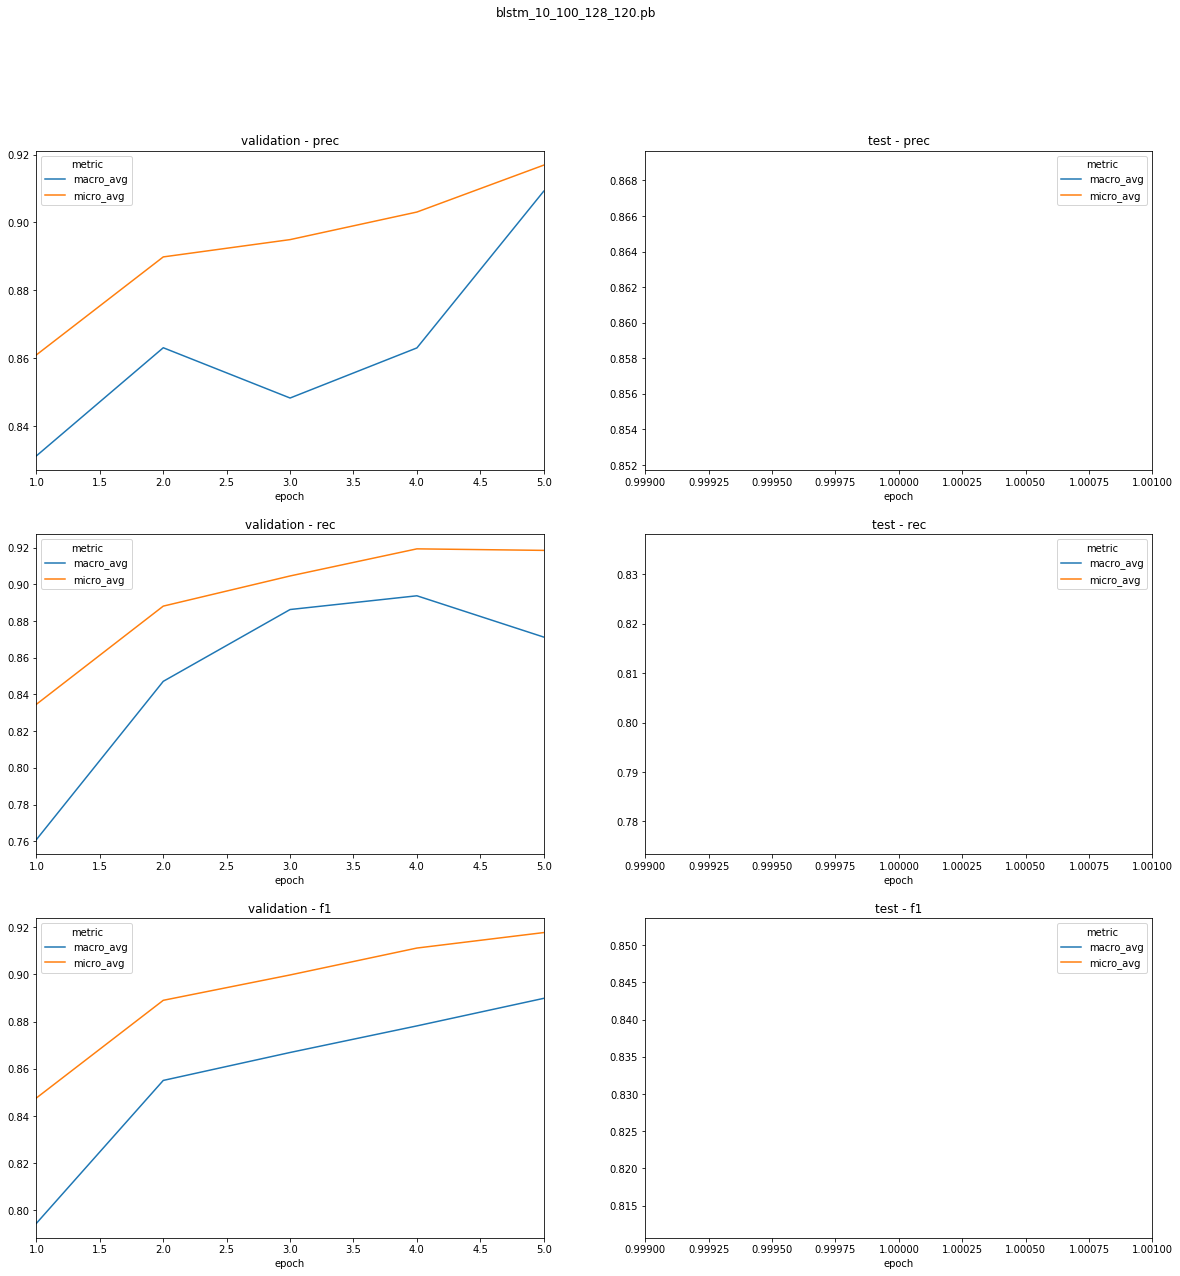

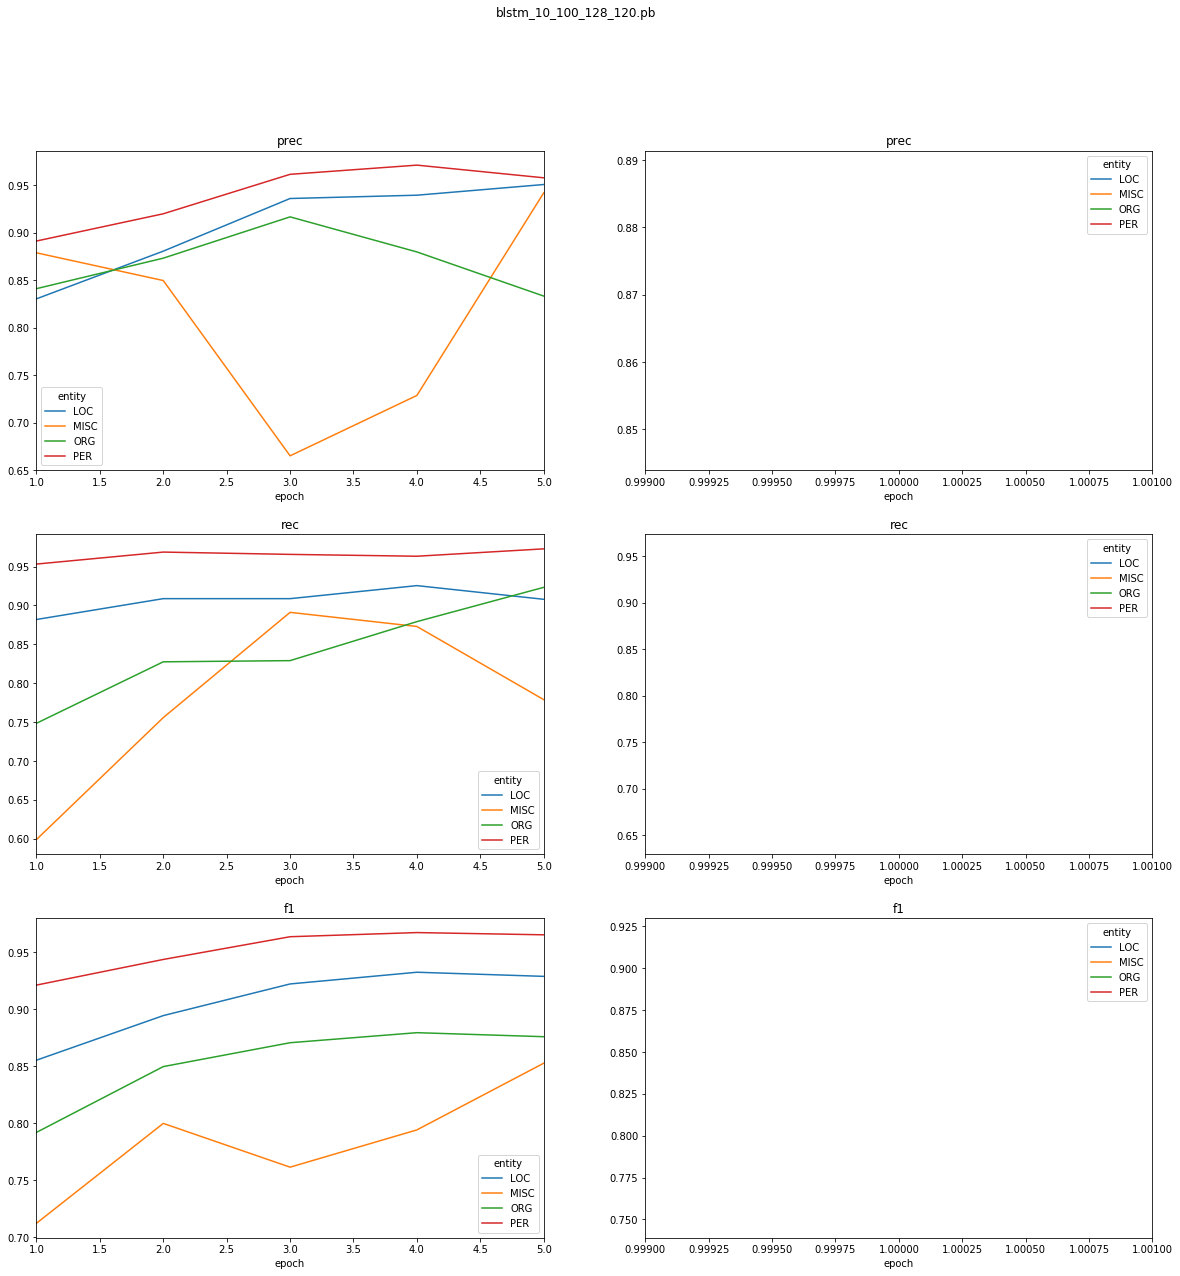

In [0]:
ner_log_parser.get_charts('/databricks/driver/ner_logs/NerDLApproach_6f65ff5a5af9.log')

### Saving the trained model

In [0]:
ner_model.stages

Out[146]: [WORD_EMBEDDINGS_MODEL_48cffc8b9a76, NerDLModel_2435b275be9d]

In [0]:
%sh cd /databricks/driver/ && ls -la

total 4080
drwxr-xr-x 1 root root 4096 Oct 30 10:18 .
drwxr-xr-x 1 root root 4096 Oct 30 08:57 ..
drwxr-xr-x 2 root root 4096 Jan 1 1970 conf
-rw-r--r-- 1 root root 7431 Oct 30 09:18 conll_eval.py
-rw-r--r-- 1 root root 7431 Oct 30 10:18 conll_eval.py.1
-rw-r--r-- 1 root root 717 Oct 30 08:58 derby.log
-rw-r--r-- 1 root root 827443 Oct 30 09:00 eng.testa
-rw-r--r-- 1 root root 3283420 Oct 30 09:00 eng.train
drwxr-xr-x 3 root root 4096 Oct 30 08:58 eventlogs
drwxr-xr-x 2 root root 4096 Oct 30 10:30 ganglia
drwxr-xr-x 2 root root 4096 Oct 30 10:01 logs
drwxr-xr-x 3 root root 4096 Oct 30 10:05 models
-rw-r--r-- 1 root root 3311 Oct 30 09:37 ner_log_parser.py
drwxr-xr-x 2 root root 4096 Oct 30 09:23 ner_logs
drwxr-xr-x 2 root root 4096 Oct 30 10:19 __pycache__

In [0]:
%sh cd /databricks/driver/models/NerDLModel_c4b4faeece72/metadata && ls -la

total 12
drwxr-xr-x 2 root root 4096 Oct 30 10:05 .
drwxr-xr-x 4 root root 4096 Oct 30 10:05 ..
-rw-r--r-- 1 root root 0 Oct 30 10:05 _SUCCESS
-rw-r--r-- 1 root root 8 Oct 30 10:05 ._SUCCESS.crc

In [0]:
ner_model.stages[1].write().overwrite().save('/databricks/driver/models/NerDLModel_3010')

In [0]:
%sh cd /databricks/driver/models && ls -la

total 12
drwxr-xr-x 3 root root 4096 Oct 30 10:05 .
drwxr-xr-x 1 root root 4096 Oct 30 10:40 ..
drwxr-xr-x 4 root root 4096 Oct 30 10:05 NerDLModel_c4b4faeece72

## Prediction Pipeline

In [0]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")
    
loaded_ner_model = NerDLModel.load("/databricks/driver/models/NerDLModel_3010")\
 .setInputCols(["sentence", "token", "embeddings"])\
 .setOutputCol("ner")

converter = NerConverter()\
  .setInputCols(["document", "token", "ner"])\
  .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        glove_embeddings,
        loaded_ner_model,
        converter])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]

In [0]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)


In [0]:
text = "Peter Parker is a nice guy and lives in New York."

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show()

+--------------------+
 text|
+--------------------+
Peter Parker is a...|
+--------------------+

In [0]:

preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip("ner_span.result","ner_span.metadata")).alias("entities")) \
.select(F.expr("entities['0']").alias("chunk"),
        F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+------------+------+
chunk |entity|
+------------+------+
Peter Parker|PER |
New York |LOC |
+------------+------+

In [0]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [0]:
text = "Peter Parker is a nice guy and lives in New York."

result = light_model.annotate(text)

list(zip(result['token'], result['ner']))

[('Peter', 'B-PER'),
 ('Parker', 'I-PER'),
 ('is', 'O'),
 ('a', 'O'),
 ('nice', 'O'),
 ('guy', 'O'),
 ('and', 'O'),
 ('lives', 'O'),
 ('in', 'O'),
 ('New', 'B-LOC'),
 ('York', 'I-LOC'),
 ('.', 'O')]

In [0]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

,sent_id,token,start,end,ner
0,0,Peter,0,4,B-PER
1,0,Parker,6,11,I-PER
2,0,is,13,14,O
3,0,a,16,16,O
4,0,nice,18,21,O
5,0,guy,23,25,O
6,0,and,27,29,O
7,0,lives,31,35,O
8,0,in,37,38,O
9,0,New,40,42,B-LOC


# creating your own CoNLL dataset¶

for a detailed overview of how to create a CoNLL file from any annotation, see here >> https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.3.prepare_CoNLL_from_annotations_for_NER.ipynb

In [0]:
import json
import os
from pyspark.ml import Pipeline
from sparknlp.base import *
from sparknlp.annotator import *
import sparknlp

spark = sparknlp.start()

def get_ann_pipeline ():
    
    document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')

    tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

    pos = PerceptronModel.pretrained() \
              .setInputCols(["sentence", "token"]) \
              .setOutputCol("pos")
    
    embeddings = WordEmbeddingsModel.pretrained()\
          .setInputCols(["sentence", "token"])\
          .setOutputCol("embeddings")

    ner_model = NerDLModel.pretrained() \
          .setInputCols(["sentence", "token", "embeddings"]) \
          .setOutputCol("ner")

    ner_converter = NerConverter()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk")

    ner_pipeline = Pipeline(
        stages = [
            document_assembler,
            sentence,
            tokenizer,
            pos,
            embeddings,
            ner_model,
            ner_converter
        ]
    )

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    ner_pipelineFit = ner_pipeline.fit(empty_data)

    ner_lp_pipeline = LightPipeline(ner_pipelineFit)

    print ("Spark NLP NER lightpipeline is created")

    return ner_lp_pipeline


conll_pipeline = get_ann_pipeline ()



pos_anc download started this may take some time.
Approximate size to download 4.3 MB
[ | ][ / ][ — ][OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[ | ][ / ][ — ][ \ ][OK!]
Spark NLP NER lightpipeline is created

In [0]:

sentences = ["Peter Parker is a nice guy and lives in New York.",
"He is also helping people around the world."]

conll_lines=''

for sentence in sentences:

  parsed = conll_pipeline.annotate (sentence)

  for token, pos, ner in zip(parsed['token'],parsed['pos'],parsed['ner']):

      conll_lines += "{} {} {} {}\n".format(token, pos, pos, ner)

  conll_lines += '\n'


print(conll_lines)

Peter NNP NNP B-PER
Parker NNP NNP I-PER
is VBZ VBZ O
a DT DT O
nice JJ JJ O
guy NN NN O
and CC CC O
lives NNS NNS O
in IN IN O
New NNP NNP B-LOC
York NNP NNP I-LOC
. . . O

He PRP PRP O
is VBZ VBZ O
also RB RB O
helping VBG VBG O
people NNS NNS O
around IN IN O
the DT DT O
world NN NN O
. . . O

# NerDL Graph

Licensed users would use this module to create graphs for each DL model (`ner_dl`, `generic_classifier`, `assertion_dl`, `relation_extraction`) in Spark NLP but in open source, you need to run the other cell.

```
%tensorflow_version 1.x

from sparknlp_jsl.training import tf_graph

tf_graph.build("ner_dl", build_params={"embeddings_dim": 200, "nchars": 80, "ntags": 12}, model_location="./", model_filename="auto")
```

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/create_graph.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/dataset_encoder.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model_saver.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/sentence_grouper.py
import sys
sys.path.append('/databricks/driver/')
sys.path.append('/databricks/driver/create_graph.py')
import create_graph
ntags = 19 # number of labels
embeddings_dim = 100
nchars =100
create_graph.create_graph(ntags, embeddings_dim, nchars)

In [0]:
%sh
ls -lt

total 31444
-rw-r--r-- 1 root root 1641858 Nov 9 21:37 blstm_15_105_128_112.pb
-rw-r--r-- 1 root root 953 Nov 9 21:37 sentence_grouper.py
-rw-r--r-- 1 root root 2484 Nov 9 21:37 ner_model_saver.py
-rw-r--r-- 1 root root 21853 Nov 9 21:37 ner_model.py
-rw-r--r-- 1 root root 2543 Nov 9 21:37 dataset_encoder.py
-rw-r--r-- 1 root root 1545 Nov 9 21:37 create_graph.py
drwxr-xr-x 2 root root 4096 Nov 9 21:30 ganglia
-rw-r--r-- 1 root root 1641858 Nov 9 21:19 blstm_19_100_128_100.pb
drwxr-xr-x 2 root root 4096 Nov 9 21:19 __pycache__
drwxr-xr-x 2 root root 4096 Nov 9 21:00 logs
-rw-r--r-- 1 root root 1504408 Nov 9 19:05 news_category_test.csv
drwxr-xr-x 2 root root 4096 Nov 9 19:02 models
drwxr-xr-x 2 root root 4096 Nov 9 18:58 ner_logs
-rw-r--r-- 1 root root 3283420 Nov 9 17:28 eng.train
-rw-r--r-- 1 root root 27 Nov 9 13:43 financial_entities.txt
-rw-r--r-- 1 root root 36 Nov 9 13:43 sport_entities.txt
-rw-r--r-- 1 root root 24032125 Nov 9 13:43 news_category_train.csv
-rw-r--r-- 1 root root 284 Nov 9 13:34 sample-sentences-en.txt
-rw-r--r-- 1 root root 724 Nov 9 09:55 derby.log
drwxr-xr-x 3 root root 4096 Nov 9 09:55 eventlogs
drwxr-xr-x 2 root root 4096 Jan 1 1970 conf

End of Notebook # 4